<a href="https://colab.research.google.com/github/Limm-jk/Data_Competition/blob/main/Find_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # 데이터 전처리
import numpy as np # 데이터 전처리
import random #데이터 전처리
from pandas import DataFrame #데이터 전처리
from collections import Counter #데이터 전처리

from tqdm import tqdm #시간 측정용

from sklearn.feature_extraction.text import CountVectorizer # model setting
from sklearn.model_selection import train_test_split  # model setting

from sklearn.naive_bayes import MultinomialNB  # model 관련
from sklearn.metrics import roc_auc_score  # model 성능 확인

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Face_News/news_train.csv")

train.head(2)

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1


In [4]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Face_News/news_test.csv")

test.head(2)

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2


In [5]:
submission=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Face_News/sample_submission.csv")

submission.head(2)

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0


In [6]:
train.shape, test.shape, submission.shape

((118745, 6), (142565, 6), (142565, 2))

In [8]:
Counter(train['info'])

Counter({0: 71813, 1: 46932})

어라? 오답이 조금 더 많네..?
어떻게할까??

편향이 걱정되니 좀 잘라서 써볼까..?

이 아래는 library 설치

In [10]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 72 (delta 31), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (72/72), done.


In [14]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [15]:
ls

images/  install_mecab-ko_on_colab190912.sh  LICENSE  README.md


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

#### 라이브러리 설치 완료

## 제목 데이터를 합치자
titie과 content를 하나로 -> text로

## 이상한 특수문자 제거!
temp = re.sub('[-=+,#/\?:^$.@*\"※~>`\'…》]', '', text)

In [79]:
train['text'] = train['title'] + " " + train['content']
test['text'] = test['title'] + " " + test['content']

In [20]:
import re

train_clear_text = list(train['text'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#/\?:^$.@*\"※~>`\'…》]', '', text)
  train_clear_text2.append(temp)
train['clear_text'] = train_clear_text2

In [33]:
import re

train_clear_text = list(test['text'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#/\?:^$.@*\"※~>`\'…》]', '', text)
  train_clear_text2.append(temp)
test['clear_text'] = train_clear_text2

In [21]:
train.shape, test.shape

((118745, 8), (142565, 7))

## 데이터 슬라이싱
0 1 차이때문에 편향이 고민되므로 잘라버리자!  
46932로 맞추는거야

하는 김에 문자의 길이도 만들어두자

In [23]:
clear_text = list(train['clear_text'])

text_lens = []

for i in tqdm(range(len(clear_text))):
  text_lens.append(len(clear_text[i]))

# text의 길이 데이터 len에 저장
train['len'] = text_lens

100%|██████████| 118745/118745 [00:00<00:00, 1497785.52it/s]


In [25]:
True_News = train[train['info'] == 0]
# 길이를 봐서 쓸만한 애들로 골라오자
True_News = True_News.sort_values(by=['len'], axis=0, ascending=False)
True_News = True_News.iloc[0:46932]

In [26]:
Fake_News = train[train['info'] == 1]

In [27]:
True_News.shape, Fake_News.shape

((46932, 9), (46932, 9))

In [31]:
# 깔끔하게 1:1이 되었다면 다시 합쳐보자
new_train = pd.concat([True_News, Fake_News])
# 깔끔하게 볼겸 섞을 겸 ㅎㅎ
new_train = new_train.sort_values(by=['ord'], axis=0, ascending=True)

del new_train['len']

new_train.head(10)

,n_id,date,title,content,ord,info,clear_text,text
37707,NEWS08612,20200304,지난달(02월) 아파트 월세 실거래가,지난 02월 아파트 월세 실거래가는 다음과 같다.서울지역의 아파트 월세가를 살펴보면...,1,0,지난달(02월) 아파트 월세 실거래가 지난 02월 아파트 월세 실거래가는 다음과 같...,지난달(02월) 아파트 월세 실거래가 지난 02월 아파트 월세 실거래가는 다음과 같...
49163,NEWS00539,20200618,디폴트 아랑곳? 아르헨 회사채 날개 달았다,[뉴욕=뉴스핌] 황숙혜 특파원 =아르헨티나가 9번째 디폴트 사태를 맞은 가운데 회사...,1,0,디폴트 아랑곳 아르헨 회사채 날개 달았다 [뉴욕뉴스핌] 황숙혜 특파원 아르헨티나가 ...,디폴트 아랑곳? 아르헨 회사채 날개 달았다 [뉴욕=뉴스핌] 황숙혜 특파원 =아르헨티...
112073,NEWS00060,20200616,SK케미칼우(28513K) 전일대비 13.7%,"SK케미칼우는 16일 9시 6분 현재 전 거래일보다 13.7% 오른 83,000원에...",1,0,SK케미칼우(28513K) 전일대비 137% SK케미칼우는 16일 9시 6분 현재 ...,SK케미칼우(28513K) 전일대비 13.7% SK케미칼우는 16일 9시 6분 현재...
37588,NEWS09835,20200410,"곧 6월인데…코로나 공지없는 MWC상하이, 여전히 참가 접수",[아시아경제 조슬기나 기자] 33년 역사상 처음으로 취소된 '모바일월드콩그레스(MW...,1,0,곧 6월인데코로나 공지없는 MWC상하이 여전히 참가 접수 [아시아경제 조슬기나 기자...,"곧 6월인데…코로나 공지없는 MWC상하이, 여전히 참가 접수 [아시아경제 조슬기나 ..."
37756,NEWS00719,20200308,[속보]천안서 50대 여성 코로나19 추가 확진…천안 91명째,"中, 코로나 바이러스 확산.. 반사 이익 수혜주는.. (테마주 단타 공략 무료 체험)",1,1,[속보]천안서 50대 여성 코로나19 추가 확진천안 91명째 中 코로나 바이러스 확...,"[속보]천안서 50대 여성 코로나19 추가 확진…천안 91명째 中, 코로나 바이러스..."
8350,NEWS02404,20200107,20대 앞세워 판 흔드는 카뱅‥규제에 흔들리는 케뱅,"카뱅, 20~30대 중심 시장 저변 넓히며 5대 시중은행 위협- 대주주 규제에 묶인...",1,0,20대 앞세워 판 흔드는 카뱅‥규제에 흔들리는 케뱅 카뱅 2030대 중심 시장 저변...,"20대 앞세워 판 흔드는 카뱅‥규제에 흔들리는 케뱅 카뱅, 20~30대 중심 시장 ..."
18610,NEWS06059,20200317,"랩지노믹스, 美 FDA로부터 코로나 진단키트 긴급사용승인 신청 요청","제목 : 랩지노믹스, 美 FDA로부터 코로나 진단키트 긴급사용승인 신청 요청",1,0,랩지노믹스 美 FDA로부터 코로나 진단키트 긴급사용승인 신청 요청 제목 랩지노믹스...,"랩지노믹스, 美 FDA로부터 코로나 진단키트 긴급사용승인 신청 요청 제목 : 랩지노..."
11755,NEWS02322,20200608,"KT, KB손해보험에 모바일 통지 서비스 도입","제목 : KT, KB손해보험에 모바일 통지 서비스 도입(지디넷코리아=박수형 기자)K...",1,0,KT KB손해보험에 모바일 통지 서비스 도입 제목 KT KB손해보험에 모바일 통지...,"KT, KB손해보험에 모바일 통지 서비스 도입 제목 : KT, KB손해보험에 모바일..."
37028,NEWS01125,20200421,"수출입銀, 두산중공업 5억달러 외화채권 대출로 전환(상보)",[아시아경제 조강욱 기자] 수출입은행이 두산중공업의 5억달러 규모 외화채권을 대출로...,1,0,수출입銀 두산중공업 5억달러 외화채권 대출로 전환(상보) [아시아경제 조강욱 기자]...,"수출입銀, 두산중공업 5억달러 외화채권 대출로 전환(상보) [아시아경제 조강욱 기자..."
41404,NEWS08981,20200405,"[신상 뜯어보기]야식 먹은 날, 호박즙 반쪽 크림으로 붓기 완벽 케어",[아시아경제 이선애 기자] 본격적으로 봄이 찾아와 사람들의 옷차림이 가벼워지는 것이...,1,0,[신상 뜯어보기]야식 먹은 날 호박즙 반쪽 크림으로 붓기 완벽 케어 [아시아경제 이...,"[신상 뜯어보기]야식 먹은 날, 호박즙 반쪽 크림으로 붓기 완벽 케어 [아시아경제 ..."


## 사용할 만한 테스트 셋이 만들어졌다.

In [28]:
from konlpy.tag import Okt
from konlpy.tag import Mecab
okt = Okt()
mecab = Mecab()

In [35]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [36]:
from tqdm import tqdm
X_train = []

text = list(new_train['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = okt.morphs(text[i], stem=True) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_train.append(temp_X)

100%|██████████| 93864/93864 [08:53<00:00, 176.04it/s]


In [37]:
from tqdm import tqdm
X_test = []

text = list(test['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = okt.morphs(text[i], stem=True) # 토큰화
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_test.append(temp_X)

100%|██████████| 142565/142565 [14:41<00:00, 161.65it/s]


In [38]:
from keras.preprocessing.text import Tokenizer
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [39]:
print(X_train[:3])

[[589, 11448, 256, 2998, 27, 97, 11448, 256, 2998, 27, 135, 436, 229, 62, 51, 256, 2998, 2846, 975, 2352, 48, 13538, 6, 293, 17727, 2998, 48, 4664, 6, 293, 16123, 1954, 5969, 26822, 23115, 830, 2294, 256, 256, 414, 1366, 16124, 135, 2352, 26823, 2998, 6583, 48, 135, 2834, 8009, 3739, 256, 414, 1366, 23116, 135, 2352, 17727, 2998, 21483, 293, 135, 261, 1093, 284, 51, 256, 2998, 135, 2352, 48, 17728, 6, 293, 2365, 2998, 48, 11973, 6, 293, 5382, 1954, 15177, 26824, 7523, 256, 414, 1366, 26825, 135, 2352, 3404, 2998, 2999, 48, 135, 26826, 26827, 7846, 7524, 256, 414, 1366, 26828, 135, 2352, 2365, 2998, 10309, 293, 135, 261, 1093, 157, 51, 256, 2998, 135, 2352, 48, 13538, 6, 293, 7090, 2998, 48, 6583, 6, 293, 17729, 1954, 11974, 26829, 13539, 443, 256, 414, 1366, 16124, 135, 2352, 23117, 2998, 6583, 48, 135, 17730, 23118, 26830, 256, 414, 1366, 26831, 135, 2352, 7090, 2998, 17729, 293, 135, 261, 1093, 166, 51, 256, 2998, 135, 2352, 48, 388, 6, 293, 4070, 4572, 2998, 48, 8849, 6, 293, 21483,

In [40]:
print(X_test[:3])

[[435, 6024, 2009, 4087, 66, 21975, 72, 1475, 408, 2009, 4087, 79, 433, 1743, 2933, 7927, 230, 13, 143, 4567, 2309, 1358, 109], [435, 6024, 2009, 4087, 66, 21975, 72, 1475, 408, 795, 74, 447, 433, 230, 95, 2009, 21589, 4087, 81, 966, 435, 7, 1], [435, 6024, 2009, 4087, 66, 21975, 72, 1475, 408, 160, 855, 230, 27, 2839, 39, 433, 1743, 2933, 87, 1358, 3968, 2532, 1]]


문자의 최대 길이 : 929
문자의 평균 길이 :  22.790207108156483


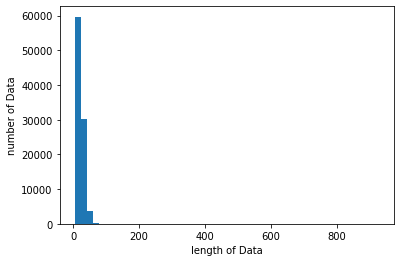

In [41]:
import matplotlib.pyplot as plt

print("문자의 최대 길이 :" , max(len(l) for l in X_train))
print("문자의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

문자의 최대 길이 : 419
문자의 평균 길이 :  20.260730193245188


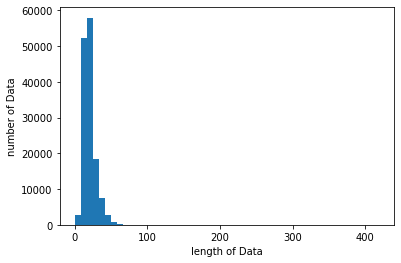

In [42]:
import matplotlib.pyplot as plt

print("문자의 최대 길이 :" , max(len(l) for l in X_test))
print("문자의 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

## 원핫인코딩

In [45]:
from keras.utils import np_utils
import numpy as np

y_train = []

for i in range(len(new_train['info'])):
  if new_train['info'].iloc[i] == 1:
    y_train.append([0, 1])
  elif new_train['info'].iloc[i] == 0:
    y_train.append([1, 0])

y_train = np.array(y_train)

In [48]:
print(y_train[:5])

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]]


In [49]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [50]:
max_len = 929 # 전체 데이터의 길이를 929로 맞춘다

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [51]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Epoch 1/2
2640/2640 [==============================] - 2940s 1s/step - loss: 0.0522 - accuracy: 0.9817 - val_loss: 0.0074 - val_accuracy: 0.9987
Epoch 2/2
2640/2640 [==============================] - 2995s 1s/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0046 - val_accuracy: 0.9986


KeyError: ignored

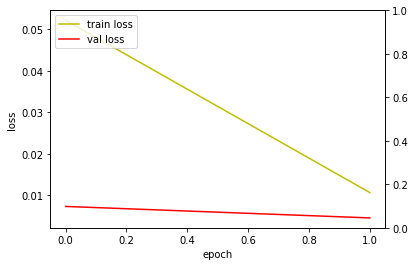

In [58]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
score = model.evaluate(X_test, test['info'], batch_size=32)

In [63]:
mypredict = model.predict(X_test)

In [64]:
submission.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [84]:
submission_ids = test['id']
my_result = []

for i in range(len(mypredict)):
  my_result.append(int(mypredict[i][1]>=mypredict[i][0]))

sub_dict = {"id":submission_ids, "info":my_result}
submission_df = pd.DataFrame(sub_dict)
submission_df.to_csv("news1.csv", index=False, encoding='utf-8')
pd.read_csv("news1.csv")

,id,info
0,NEWS00237_1,1
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0
...,...,...
142560,NEWS09482_72,1
142561,NEWS09482_73,1
142562,NEWS09482_74,1
142563,NEWS09482_75,1


In [71]:
ls

drive/                       mecab-ko-dic-2.1.1-20180720/        news1.csv
mecab-0.996-ko-0.9.2/        mecab-ko-dic-2.1.1-20180720.tar.gz  sample_data/
mecab-0.996-ko-0.9.2.tar.gz  Mecab-ko-for-Google-Colab/


In [82]:
test.head()

,n_id,date,title,content,ord,id,text,clear_text
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 마이크로 LED T...",[주목!e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 마이크로 LED TV...
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 [이데일리 김대웅 ...",[주목!e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 [이데일리 김대웅 기...
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 최근 대형 업체들과...",[주목!e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 최근 대형 업체들과 ...
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 TV를 필두로 올해...",[주목!e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 TV를 필두로 올해부...
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대 코세스는 반도체 장...",[주목!e스몰캡]코세스 마이크로LED 시장 개화 최대수혜 기대 코세스는 반도체 장비...
